In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def load_data(train_batch_size, test_batch_size):
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=train_batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=test_batch_size, shuffle=True)
    return (train_loader, test_loader)

In [7]:
 class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [12]:
train_batch_size = 64
test_batch_size = 1000
train_loader, test_loader = load_data(train_batch_size, test_batch_size)

Files already downloaded and verified


In [13]:
def train(model, optimizer, epoch, train_loader, log_interval):
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    n_correct = 0
    train_loss = 0
    counter = 0
    n_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        counter += 1
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # Forward propagation
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.data

        pred = np.argmax(output.data, axis=1)
        n_samples += target.size(0)
        n_correct += (pred == target).sum().item()
        acc = 100.0 * n_correct / n_samples

        # print log
        if batch_idx % log_interval == 0:
            print('Train set, Epoch {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss.data))
            print("Train Accuracy: ", round(acc,2))
    train_loss /= counter
    return train_loss, round(acc,2)


In [17]:
def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        
        output = model(data)
        test_loss += loss_fn(output, target).data

        pred = np.argmax(output.data, axis=1)
        correct = correct + np.equal(pred, target.data).sum()

    # Print log
    test_loss /= len(test_loader.dataset)
    print('\nTest set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [19]:
model= LeNet()

lr = 0.001
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr, momentum)
m0_loss_arr = []
m0_acc_arr = []

epochs = 10
log_interval = 200
for epoch in range(1, epochs + 1):
    loss, acc = train(model, optimizer, epoch, train_loader, log_interval)
    m0_loss_arr.append(loss)
    m0_acc_arr.append(acc)
    test(model, epoch, test_loader)

Train set, Epoch 1 [0/50000]	Loss: 2.302392
Train Accuracy:  14.06
Train set, Epoch 1 [12800/50000]	Loss: 2.297323
Train Accuracy:  9.96
Train set, Epoch 1 [25600/50000]	Loss: 2.301378
Train Accuracy:  10.07
Train set, Epoch 1 [38400/50000]	Loss: 2.302758
Train Accuracy:  10.17

Test set, Epoch 1 , Average loss: 2.2945, Accuracy: 1589/10000 (16%)

Train set, Epoch 2 [0/50000]	Loss: 2.287512
Train Accuracy:  25.0
Train set, Epoch 2 [12800/50000]	Loss: 2.291099
Train Accuracy:  15.08
Train set, Epoch 2 [25600/50000]	Loss: 2.190733
Train Accuracy:  15.02
Train set, Epoch 2 [38400/50000]	Loss: 2.187953
Train Accuracy:  15.92

Test set, Epoch 2 , Average loss: 2.1328, Accuracy: 2371/10000 (24%)

Train set, Epoch 3 [0/50000]	Loss: 2.163499
Train Accuracy:  28.12
Train set, Epoch 3 [12800/50000]	Loss: 2.114242
Train Accuracy:  23.76
Train set, Epoch 3 [25600/50000]	Loss: 2.076852
Train Accuracy:  24.45
Train set, Epoch 3 [38400/50000]	Loss: 1.953592
Train Accuracy:  25.19

Test set, Epoch 3 ,

In [18]:
model_2= Net()

lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model_2.parameters(), lr=lr, momentum=momentum)
m1_loss_arr = []
m1_acc_arr = []

epochs = 10
log_interval = 100
for epoch in range(1, epochs + 1):
    loss, acc = train(model_2, optimizer, epoch, train_loader, log_interval=log_interval)
    m1_loss_arr.append(loss)
    m1_acc_arr.append(acc)
    test(model_2, epoch, test_loader)

Train set, Epoch 1 [0/50000]	Loss: 2.299510
Train Accuracy:  10.94
Train set, Epoch 1 [6400/50000]	Loss: 2.300259
Train Accuracy:  10.67
Train set, Epoch 1 [12800/50000]	Loss: 2.291364
Train Accuracy:  11.11
Train set, Epoch 1 [19200/50000]	Loss: 2.247506
Train Accuracy:  12.0
Train set, Epoch 1 [25600/50000]	Loss: 2.188226
Train Accuracy:  13.89
Train set, Epoch 1 [32000/50000]	Loss: 2.187641
Train Accuracy:  15.49
Train set, Epoch 1 [38400/50000]	Loss: 1.869187
Train Accuracy:  17.18
Train set, Epoch 1 [44800/50000]	Loss: 1.832759
Train Accuracy:  18.72


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set, Epoch 1 , Average loss: 1.8879, Accuracy: 3089/10000 (31%)

Train set, Epoch 2 [0/50000]	Loss: 1.924680
Train Accuracy:  25.0
Train set, Epoch 2 [6400/50000]	Loss: 1.799953
Train Accuracy:  30.63
Train set, Epoch 2 [12800/50000]	Loss: 1.817247
Train Accuracy:  30.75
Train set, Epoch 2 [19200/50000]	Loss: 1.723490
Train Accuracy:  31.51
Train set, Epoch 2 [25600/50000]	Loss: 1.979966
Train Accuracy:  32.17
Train set, Epoch 2 [32000/50000]	Loss: 1.911735
Train Accuracy:  32.62
Train set, Epoch 2 [38400/50000]	Loss: 1.485999
Train Accuracy:  33.0
Train set, Epoch 2 [44800/50000]	Loss: 1.696311
Train Accuracy:  33.52

Test set, Epoch 2 , Average loss: 1.6057, Accuracy: 4204/10000 (42%)

Train set, Epoch 3 [0/50000]	Loss: 1.806012
Train Accuracy:  39.06
Train set, Epoch 3 [6400/50000]	Loss: 1.741914
Train Accuracy:  37.41
Train set, Epoch 3 [12800/50000]	Loss: 1.610001
Train Accuracy:  38.32
Train set, Epoch 3 [19200/50000]	Loss: 1.424665
Train Accuracy:  38.87
Train set, Epoch 3

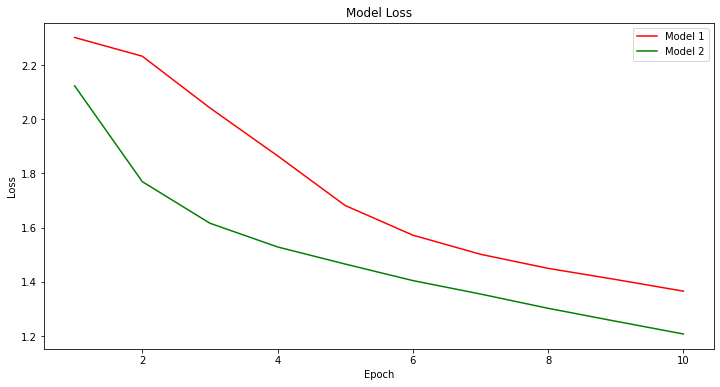

In [20]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 11, 1), m0_loss_arr, color = "r")
plt.plot(np.arange(1, 11, 1), m1_loss_arr, color = "g")
plt.title('Model Loss')
plt.legend(['Model 1', 'Model 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

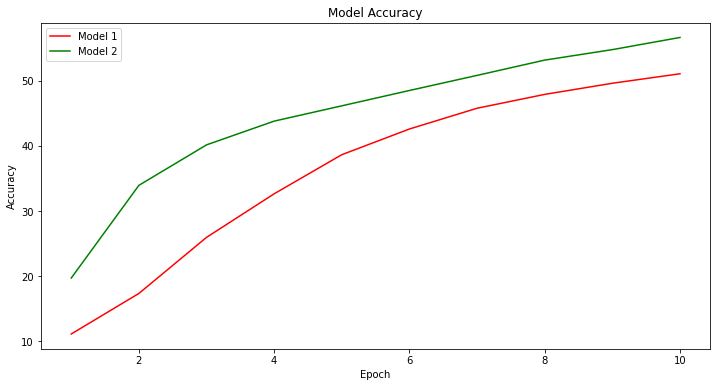

In [21]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, 11, 1), m0_acc_arr, color = "r")
plt.plot(np.arange(1, 11, 1), m1_acc_arr, color = "g")
plt.title('Model Accuracy')
plt.legend(['Model 1', 'Model 2'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()